In [1]:
import yaml
import os 
import gzip
import cloudpickle

import awkward as ak
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep

import hist
from hist import Hist

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from topcoffea.modules.histEFT import HistEFT
NanoAODSchema.warn_missing_crossrefs = False

from coffea.analysis_tools import PackedSelection
from topcoffea.modules import utils
import topcoffea.modules.eft_helper as efth

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import dctr.modules.plotting_tools as plt_tools
import dctr.modules.DNN_tools as DNN_tools

In [13]:
# means and stdv to standardize pd df for input into trained model
# means = {'avg_top_pt': 34.263557,
#         'mtt': 522.141900,
#         'top1pt': 126.859184,
#         'top1eta': -0.257265,
#         'top1phi': -0.000021,
#         'top1mass': 172.253560,
#         'top2pt': 124.636566,
#         'top2eta': 0.257370,
#         'top2phi': -0.000686,
#         'top2mass': 172.265670,}
# stdvs = {'avg_top_pt': 38.252880,
#         'mtt': 175.306980,
#         'top1pt': 84.604750,
#         'top1eta': 1.823326,
#         'top1phi': 1.813635,
#         'top1mass': 5.346320,
#         'top2pt': 82.644310,
#         'top2eta': 1.829129,
#         'top2phi': 1.813916,
#         'top2mass': 5.329451,}

means = {'avg_top_pt': 34.37594,
        'mtt': 522.8204,
        'top1pt': 145.54019,
        'top1eta': -0.00080191356,
        'top1phi': 0.0002472976,
        'top1mass': 172.4881,
        'top2pt': 106.316284,
        'top2eta': 0.0002492254,
        'top2phi': -0.00088213355,
        'top2mass': 172.44499,}
stdvs = {'avg_top_pt': 38.34243,
        'mtt': 175.4714,
        'top1pt': 88.27853,
        'top1eta': 1.6881704,
        'top1phi': 1.8136373,
        'top1mass': 3.0224695,
        'top2pt': 73.93133,
        'top2eta': 1.9869514,
        'top2phi': 1.8138397,
        'top2mass': 3.067736,}

In [3]:
axes = {
    "outputs": {
        "regular": (100, 0, 1),
        "label": "outputs",},
    "top1pt": {
        "regular": (35, 0, 700),
        "label": "top1 pt",},
    "top2pt": {
        "regular": (35, 0, 700),
        "label": "top2 pt",},
    "toppt": {
        "regular": (35, 0, 700),
        "label": "top pt",},
    "antitoppt": {
        "regular": (35, 0, 700),
        "label": "antitop pt",},
    "top1eta": {
        "regular": (50, -5, 5),
        "label": "top1 eta",},
    "top2eta": {
        "regular": (50, -5, 5),
        "label": "top2 eta",},
    "topeta": {
        "regular": (50, -5, 5),
        "label": "top eta",},
    "antitopeta": {
        "regular": (50, -5, 5),
        "label": "antitop eta",},
    "top1phi": {
        "regular": (40, -4, 4),
        "label": "top1 phi",},
    "top2phi": {
        "regular": (40, -4, 4),
        "label": "top2 phi",},
    "topphi": {
        "regular": (40, -4, 4),
        "label": "top phi",},
    "antitopphi": {
        "regular": (40, -4, 4),
        "label": "antitop phi",}, 
    "top1mass": {
        "regular": (34, 80, 250),
        "label": "top1 mass", },
    "top2mass": {
        "regular": (34, 80, 250),
        "label": "top2 mass", },
    "topmass": {
        "regular": (34, 80, 250),
        "label": "top mass", },
    "antitopmass": {
        "regular": (34, 80, 250),
        "label": "antitop mass", }, 
    "j0pt": {
        "regular": (100, 0, 500),
        "label": "j0pt",},
    "j0eta": {
        "regular": (50, -5, 5), 
        "label": "j0eta",},
    "j0phi": {
        "regular": (40, -4, 4),
        "label": "j0phi",},
    "j0mass": {
        "regular": (10, 0, 100),
        "label": "j0mass"},
    "njets": {
        "regular": (10, 0, 10),
        "label": "njets"},
    "mtt": {
        "regular": (75, 0, 1500),
        "label": "mtt"},
}

In [4]:
fpowheg = "/cms/cephfs/data/store/mc/RunIISummer20UL17NanoAODv9/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/2510000/74C36AED-4CB9-1A4D-A9E6-90278C68131C.root"
fsmeft  = "/cms/cephfs/data/store/user/hnelson2/noEFT/nanoGen/TT01j2l_SM/NanoGen_TT01j2l_SM/nanoGen_10016.root"

In [5]:
def compute_weight(pred): 
    return pred / (1 - pred + 1e-8)

In [6]:
def get_predictions(events, config_path, model_path): 
    genpart = events.GenPart
    is_final_mask = genpart.hasFlags(["fromHardProcess","isLastCopy"])

    gen_top = ak.pad_none(genpart[is_final_mask & (abs(genpart.pdgId) == 6)],2)
    gen_top = gen_top[ak.argsort(gen_top.pt, axis=1, ascending=False)]

    ### Fill df with inputs to run through trained model
    variables_to_fill_df = {
        "avg_top_pt": np.divide(gen_top.sum().pt, 2.0),
        "mtt"       : (gen_top[:,0] + gen_top[:,1]).mass,
        "top1pt"    : gen_top.pt[:,0],
        "top1eta"   : gen_top.eta[:,0],
        "top1phi"   : gen_top.phi[:,0],
        "top1mass"  : gen_top.mass[:,0],
        "top2pt"    : gen_top.pt[:,1],
        "top2eta"   : gen_top.eta[:,1],
        "top2phi"   : gen_top.phi[:,1],
        "top2mass"  : gen_top.mass[:,1],
    }

    # NN_inputs = pd.DataFrame.from_dict(variables_to_fill_df)
    norm_NN_inputs = DNN_tools.standardize_df(pd.DataFrame.from_dict(variables_to_fill_df), means, stdvs)
    
    ### load in trained network 
    print(f"loading in trained network")

    with open(config_path, 'r') as f:
            config_dict = yaml.safe_load(f)

    model_architecture = config_dict['model']
    input_dim = norm_NN_inputs.shape[1]
    model = DNN_tools.NeuralNetwork(input_dim, model_architecture)

    model.load_state_dict(torch.load(model_path))

    ### Evaluate the trained model with my random powheg sample
    print(f"evaluating network with the standardized inputs")
    model.eval()
    predictions = DNN_tools.get_predictions(model, torch.from_numpy(norm_NN_inputs.to_numpy()))
    print(f"predictions from model retrieved")
    
    return predictions

In [7]:
def main(file, config_path, model_path): 
    # Load in events from root file
    events = NanoEventsFactory.from_root(
        file,
        schemaclass=NanoAODSchema.v6,
        metadata={"dataset": "TTto2L2Nu"},
    ).events()
    
    genpart = events.GenPart
    is_final_mask = genpart.hasFlags(["fromHardProcess","isLastCopy"])

    gen_top = ak.pad_none(genpart[is_final_mask & (abs(genpart.pdgId) == 6)],2)
    gen_top = gen_top[ak.argsort(gen_top.pt, axis=1, ascending=False)]
    
    jets = events.GenJet
    jets = jets[ak.argsort(jets.pt, axis=-1, ascending=False)]
    j0 = jets[ak.argmax(jets.pt, axis=-1, keepdims=True)]
    njets = ak.num(jets)
    
    predictions = get_predictions(events, config_path, model_path)
    
    reweights = compute_weight(predictions)
    weights = reweights.flatten()
    
    print(f"initializing empty histograms")
    histos = {}
    histos_reweighted = {}
    
    for name, info in axes.items():
        dense_axis = hist.axis.Regular(*info['regular'], name=name, label=info['label'])
        histos[name] = Hist(dense_axis, storage='weight')
        histos_reweighted[name] = Hist(dense_axis, storage='weight')
        
    variables_to_fill = {
        "outputs":      predictions, 
        "mtt":          (gen_top[:,0] + gen_top[:,1]).mass,
        "top1pt":       gen_top[:,0].pt,
        "top2pt":       gen_top[:,1].pt, 
        "njets":        njets,
        }
    
    print(f"filling histograms...")
    for var_name, var_val in variables_to_fill.items():
        histos[var_name].fill(**{var_name: var_val}, weight=weights)
        histos_reweighted[var_name].fill(**{var_name: var_val})
        
    print(f"done filling histograms")
    
    return histos, histos_reweighted

In [8]:
def get_ratio_uncertainty(num_hist, denom_hist):
    '''
    Calculates the propagated uncertainty per bin on the ratio of two historgams

    Parameters
    ----------
        num_hist (scikithep hist): numerator histogram
        denom_hist (scikithep hist): Denominator histogram
    
    Returns:
        list of uncertainties, one entry per histogram bin
    '''

    xvals = num_hist.axes.centers[0]
    yvals_num = num_hist.values()
    yvals_denom = denom_hist.values()
    sigma_num = np.sqrt(num_hist.variances())
    sigma_denom = np.sqrt(denom_hist.variances())

    ratio = np.divide(yvals_num, yvals_denom)

    # calculation for error propagation for ratio = yavls_num/yvals_denom
    # generally, z=x/y; sigma_z = abs(z)sqrt((sigma_x/x)^2+(sigma_y/y)^2)
    sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))

    return sigma_y

def get_ratio_points(num_hist, denom_hist):
    '''
    Calculates the ratio between two histograms

    Parameters
    ----------
        num_hist (scikithep hist): numerator histogram
        denom_hist (scikithep hist): Denominator histogram

    Returns:
        centers: list of the x-axis point that the ratio corresponds to
        ratio: list of the ratio value (one for each hist bin)
    '''

    num = num_hist.values()
    centers = num_hist.axes.centers[0]
    denom = denom_hist.values()
    ratio = np.divide(num, denom)

    return centers, ratio

In [14]:
config_file = "/users/hnelson2/dctr/condor_submissions/20250730_130752/config.yaml"
model_file = "/users/hnelson2/dctr/condor_submissions/20250730_130752/training_outputs/final_model.pt"
smeft_histos, smeft_reweighted = main(fsmeft, config_file, model_file)
powheg_histos, powheg_reweights = main(fpowheg, config_file, model_file)

loading in trained network
evaluating network with the standardized inputs
predictions from model retrieved
initializing empty histograms
filling histograms...
done filling histograms
loading in trained network
evaluating network with the standardized inputs
predictions from model retrieved
initializing empty histograms
filling histograms...
done filling histograms


In [11]:
def normalize_hist(h):
    
    counts = h.values()
    bin_edges = h.axes[0].edges
    bin_widths = np.diff(bin_edges)
    
    area = np.sum(counts * bin_widths)
    
    return counts/area

Text(0.5, 1.0, 'Normalized to 1.0')

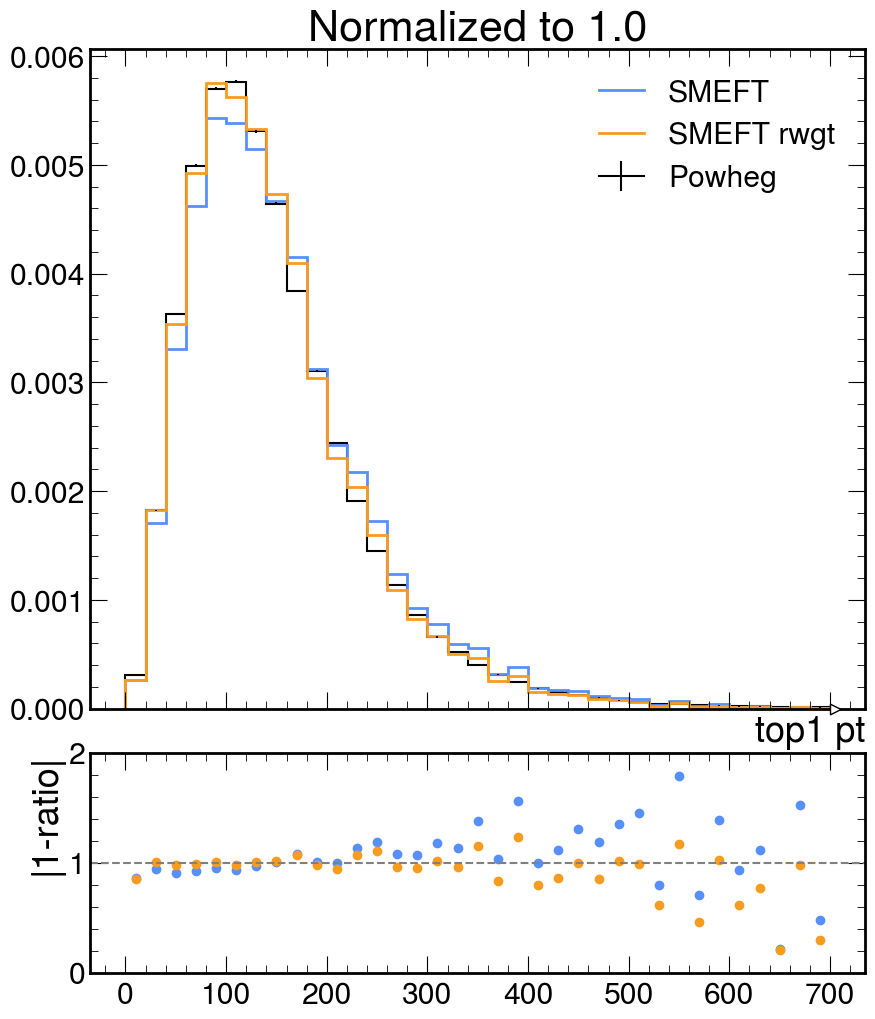

In [15]:
name = "top1pt"

h_powheg = powheg_histos[name]
h_smeft = smeft_histos[name]
h_smeft_rwgt = smeft_reweighted[name]

h_powheg_norm = normalize_hist(h_powheg)
h_smeft_norm = normalize_hist(h_smeft)
h_smeft_rwgt_norm = normalize_hist(h_smeft_rwgt)

centers = h_powheg.axes.centers[0]
edges = h_powheg.axes[0].edges

smeft_ratio = h_smeft_norm/h_powheg_norm
smeft_rwgt_ratio = h_smeft_rwgt_norm/h_powheg_norm

hep.style.use("CMS")
# Initialize figure and axes
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,12),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.1)

# Plot histograms with errors
hep.histplot(h_powheg, ax=ax, density=True, yerr=True, label="Powheg", color='black')
# hep.histplot(h_powheg_norm, bins=edges, ax=ax, stack=False, yerr=False, linewidth=2, label="Powheg normalized", color='black')
hep.histplot(h_smeft_norm, bins=edges, ax=ax, stack=False, yerr=False, linewidth=2, label="SMEFT")
hep.histplot(h_smeft_rwgt_norm, bins=edges, ax=ax, stack=False, yerr=False, linewidth=2, label="SMEFT rwgt")

# Plot ratio with errors
rax.scatter(centers, smeft_ratio)
rax.scatter(centers, smeft_rwgt_ratio)
rax.set_ylim([0, 2])
rax.axhline(y=1.0, color='gray', linestyle='--')

# dev_smeft = np.abs(1-smeft_ratio)
# dev_rwgt = np.abs(1-smeft_rwgt_ratio)
# rax.scatter(centers, dev_smeft)
# rax.scatter(centers, dev_rwgt)
# rax.set_ylim([0, 0.8])
# rax.axhline(y=0.5, color='gray', linestyle='--')

rax.set_ylabel("|1-ratio|")

ax.legend(loc='best')
ax.set_title("Normalized to 1.0")